## Installing the Nvidia GPU

In [ ]:
!nvidia-smi

Wed May  8 13:52:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Importing Libraries & Frameworks

In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv5

In [ ]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5

%cd {HOME}/yolov5
!pip install -r requirements.txt

from IPython import display
display.clear_output()

## Install YOLOv8

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


## Install Detectron2

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


## Install Supervision

In [ ]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


##Detecting Humans in the Image

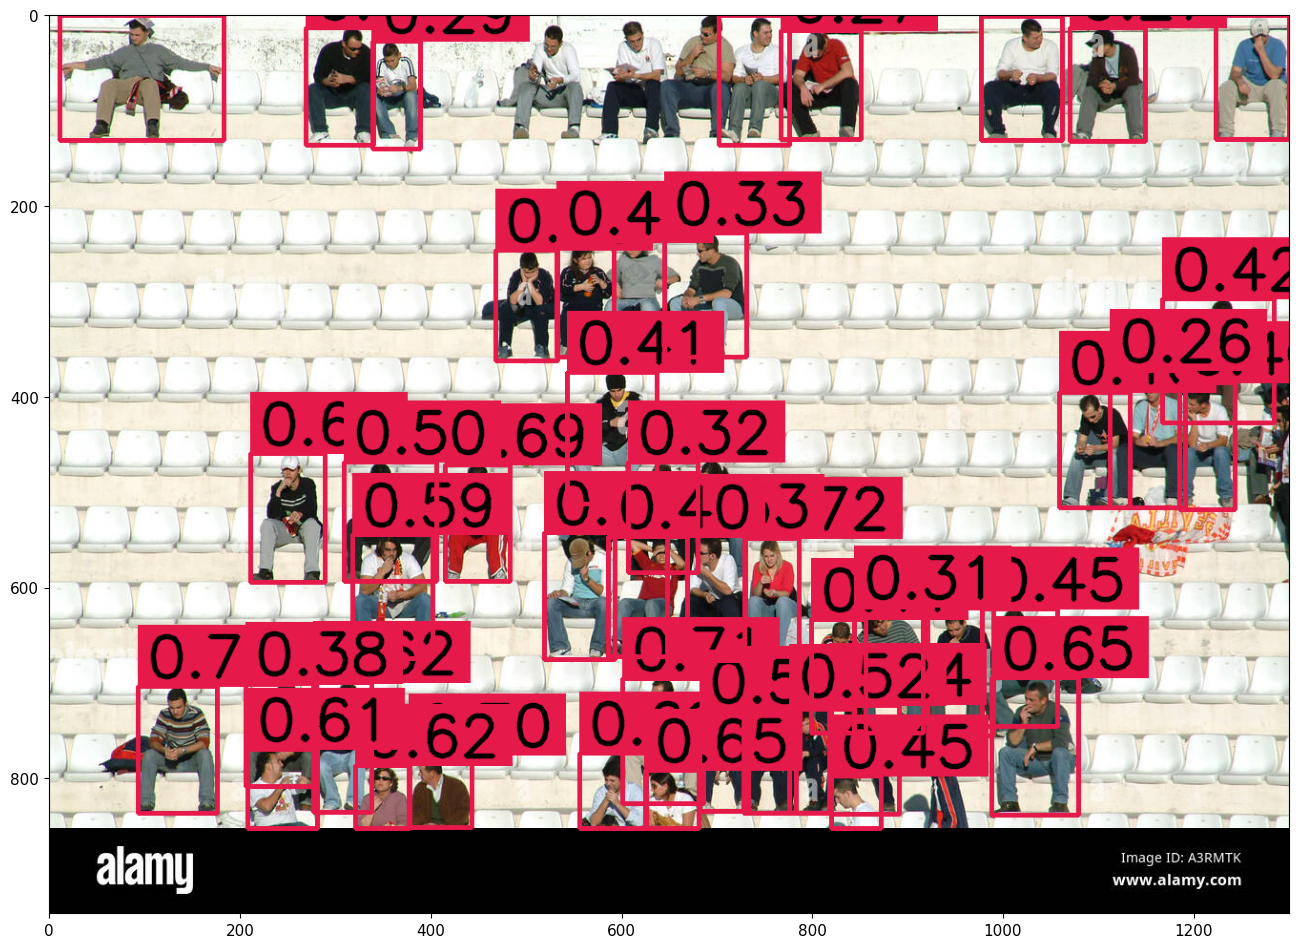

In [ ]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
image_path = "crowd-4.jpeg"
frame = cv2.imread(image_path)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)

# Filter out class_id values that are not 0
filtered_detections = sv.Detections(
    xyxy=detections.xyxy[detections.class_id == 0],
    confidence=detections.confidence[detections.class_id == 0],
    class_id=detections.class_id[detections.class_id == 0],
    tracker_id=None
)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=filtered_detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))


## Creating Multiple Frames & Counting the number of humans in each zone



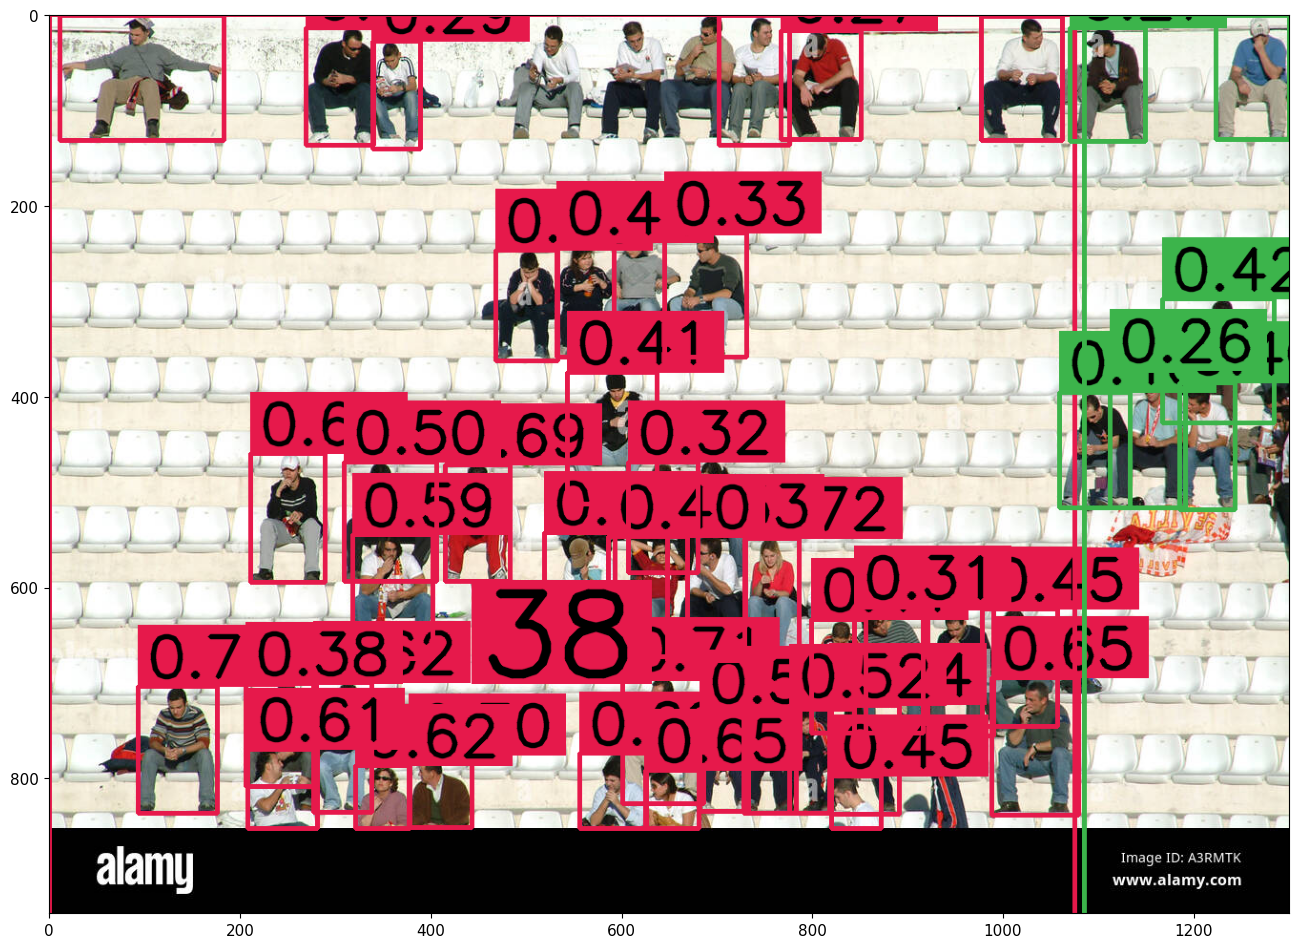

In [ ]:
import numpy as np
import supervision as sv
colors = sv.ColorPalette.default()

# initiate polygon zone
polygons = [
    np.array([
        [0, 0],
        [1080 - 5, 0],
        [1080 - 5, 1300 - 5],
        [0, 1300 - 5]
    ], np.int32),
    np.array([
        [1080 + 5, 0],
        [2160, 0],
        [2160, 1300 - 5],
        [1080 + 5, 1300 - 5]
    ], np.int32),
    np.array([
        [0, 1300 + 5],
        [1080 - 5, 1300 + 5],
        [1080 - 5, 3840],
        [0, 3840]
    ], np.int32),
    np.array([
        [1080 + 5, 1300 + 5],
        [2160, 1300 + 5],
        [2160, 3840],
        [1080 + 5, 3840]
    ], np.int32)
]
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
image_path = "crowd-4.jpeg"
frame = cv2.imread(image_path)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)

detections = sv.Detections(
    xyxy=detections.xyxy[detections.class_id == 0],
    confidence=detections.confidence[detections.class_id == 0],
    class_id=detections.class_id[detections.class_id == 0],
    tracker_id=None
)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    f_detections = [detection for i, detection in enumerate(detections) if mask[i]]
    frame = box_annotator.annotate(scene=frame, detections=f_detections)
    frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))


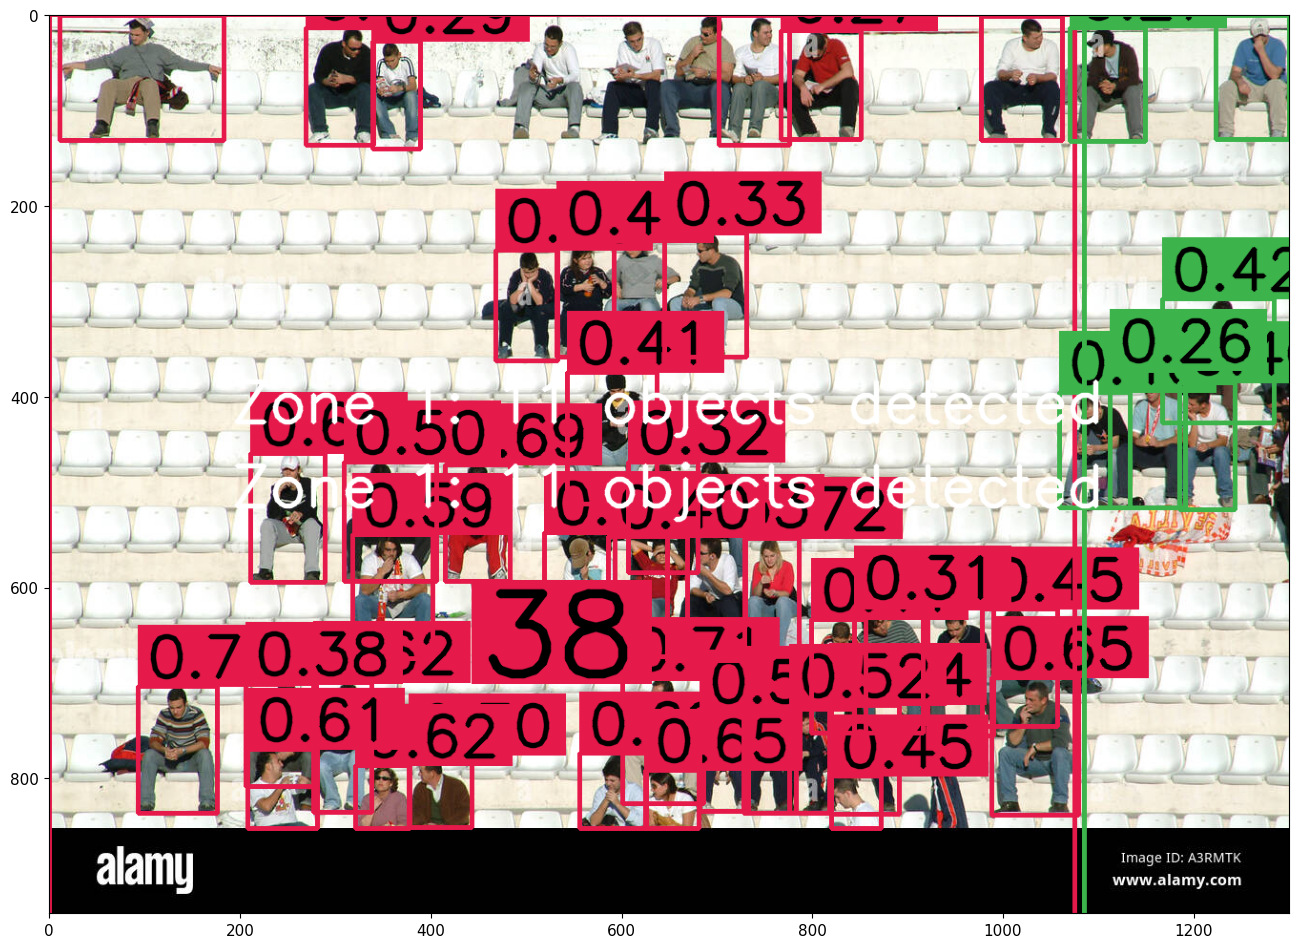

In [ ]:
import numpy as np
import supervision as sv

# Load the image
image_path = "crowd-4.jpeg"
frame = cv2.imread(image_path)

colors = sv.ColorPalette.default()

# initiate polygon zone
polygons = [
    np.array([
        [0, 0],
        [1080 - 5, 0],
        [1080 - 5, 1300 - 5],
        [0, 1300 - 5]
    ], np.int32),
    np.array([
        [1080 + 5, 0],
        [2160, 0],
        [2160, 1300 - 5],
        [1080 + 5, 1300 - 5]
    ], np.int32),
    np.array([
        [0, 1300 + 5],
        [1080 - 5, 1300 + 5],
        [1080 - 5, 3840],
        [0, 3840]
    ], np.int32),
    np.array([
        [1080 + 5, 1300 + 5],
        [2160, 1300 + 5],
        [2160, 3840],
        [1080 + 5, 3840]
    ], np.int32)
]
# Since we are using an image, we don't need video_info
# video_info = sv.VideoInfo(resolution_wh=(2160, 3840))

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]

# No need to redefine video_info since we're not using a video

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)

detections = sv.Detections(
    xyxy=detections.xyxy[detections.class_id == 0],
    confidence=detections.confidence[detections.class_id == 0],
    class_id=detections.class_id[detections.class_id == 0],
    tracker_id=None
)
zone_objects_count = {}

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    f_detections = [detection for i, detection in enumerate(detections) if mask[i]]
    frame = box_annotator.annotate(scene=frame, detections=f_detections)
    frame = zone_annotator.annotate(scene=frame)
    zone_objects_count[zone_annotators.index(zone_annotator) + 1] = num_detections_in_zone


%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))


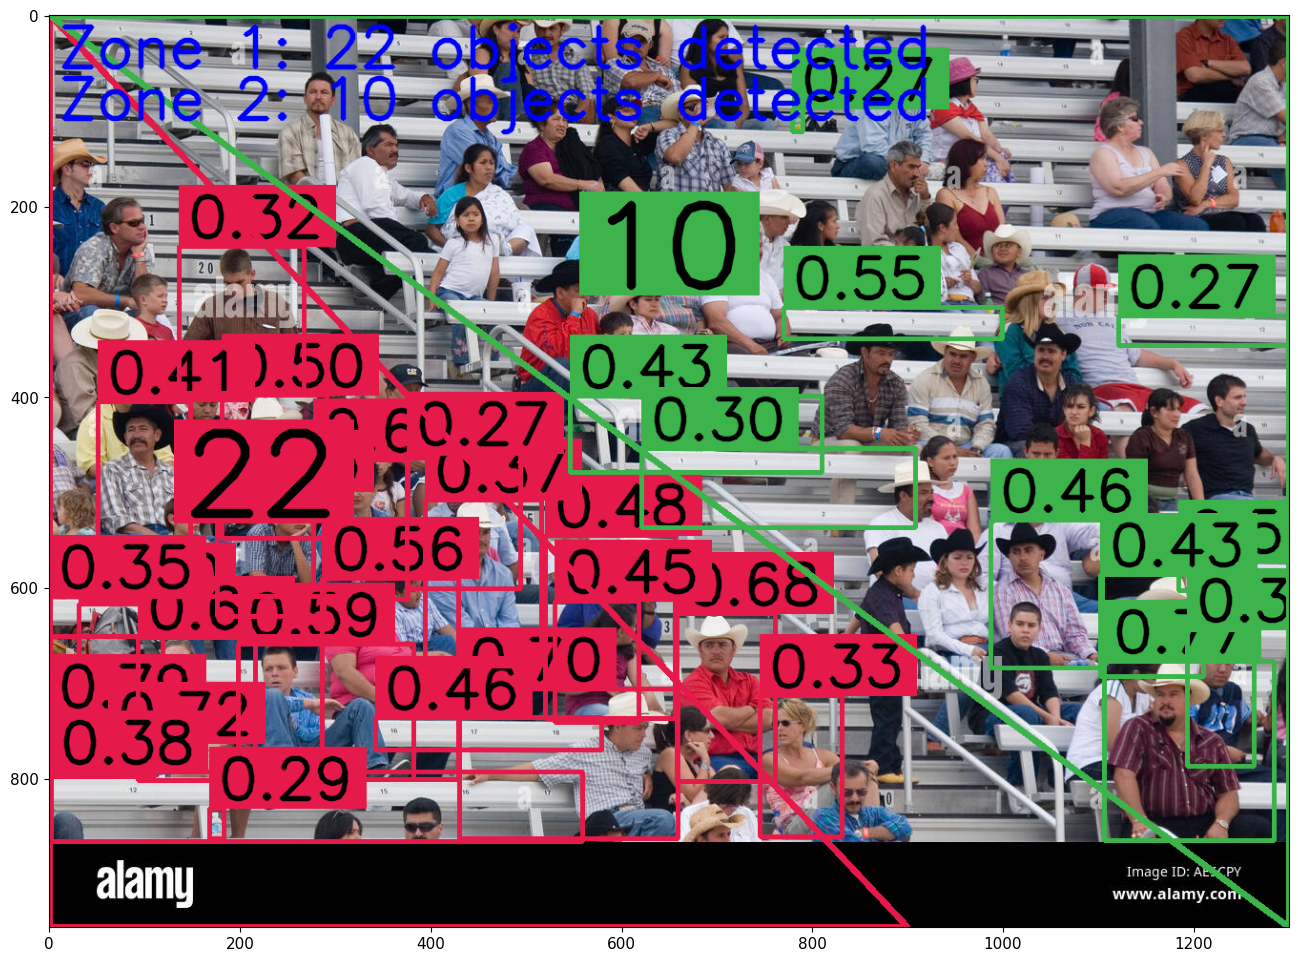

In [ ]:
import cv2
import numpy as np
import supervision as sv

# Load the image
image_path = "crowd-6.jpeg"
frame = cv2.imread(image_path)

colors = sv.ColorPalette.default()

# Define polygons to divide the image into halves diagonally
poly1 = np.array([
    [0, 0],
    [1, 0],
    [frame.shape[1] // 2 + 250, frame.shape[0]],
    [0, frame.shape[0]]
], np.int32)

poly2 = np.array([
    [0,0],
    [0,0],
    [frame.shape[1], frame.shape[0]],
    [frame.shape[1], 0]
], np.int32)


# Convert polygons to supervision PolygonZone objects
zones = [
    sv.PolygonZone(
        polygon=poly,
        frame_resolution_wh=(frame.shape[1], frame.shape[0])
    )
    for poly in [poly1, poly2]
]

# Create annotators for the zones
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=6,
        text_thickness=8,
        text_scale=4
    )
    for index, zone in enumerate(zones)
]

# Create annotators for the boxes (optional)
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
    )
    for index in range(len(zones))
]

# Detect objects in the image
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)

zone_objects_count = {}

# Filter detections for the objects in the zones
for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    f_detections = [detection for i, detection in enumerate(detections) if mask[i]]
    frame = box_annotator.annotate(scene=frame, detections=f_detections)
    frame = zone_annotator.annotate(scene=frame)
    num_detections_in_zone = sum(mask)
    zone_objects_count[zone_annotators.index(zone_annotator) + 1] = num_detections_in_zone

max_zone = max(zone_objects_count, key=zone_objects_count.get)
min_zone = min(zone_objects_count, key=zone_objects_count.get)

# Calculate center coordinates of the image
image_center = (frame.shape[1] // 2, frame.shape[0] // 2)

font_scale = 2  # Increase font size
text_thickness = 4  # Increase text thickness
text_size = cv2.getTextSize(f"Zone {max_zone}: {zone_objects_count[max_zone]} objects detected", cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_thickness)[0]

# Calculate text position for zone with highest number of objects detected (top left corner)
text_position_max = (10, 10 + text_size[1])

# Calculate text position for zone with lowest number of objects detected (below the highest text)
text_position_min = (10, text_position_max[1] + text_size[1] + 10)

# Add text annotations for zone with highest number of objects detected
cv2.putText(frame, f"Zone {max_zone}: {zone_objects_count[max_zone]} objects detected", text_position_max, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,0,0), text_thickness, cv2.LINE_AA)

# Add text annotations for zone with lowest number of objects detected
cv2.putText(frame, f"Zone {min_zone}: {zone_objects_count[min_zone]} objects detected", text_position_min, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,0,0), text_thickness, cv2.LINE_AA)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))


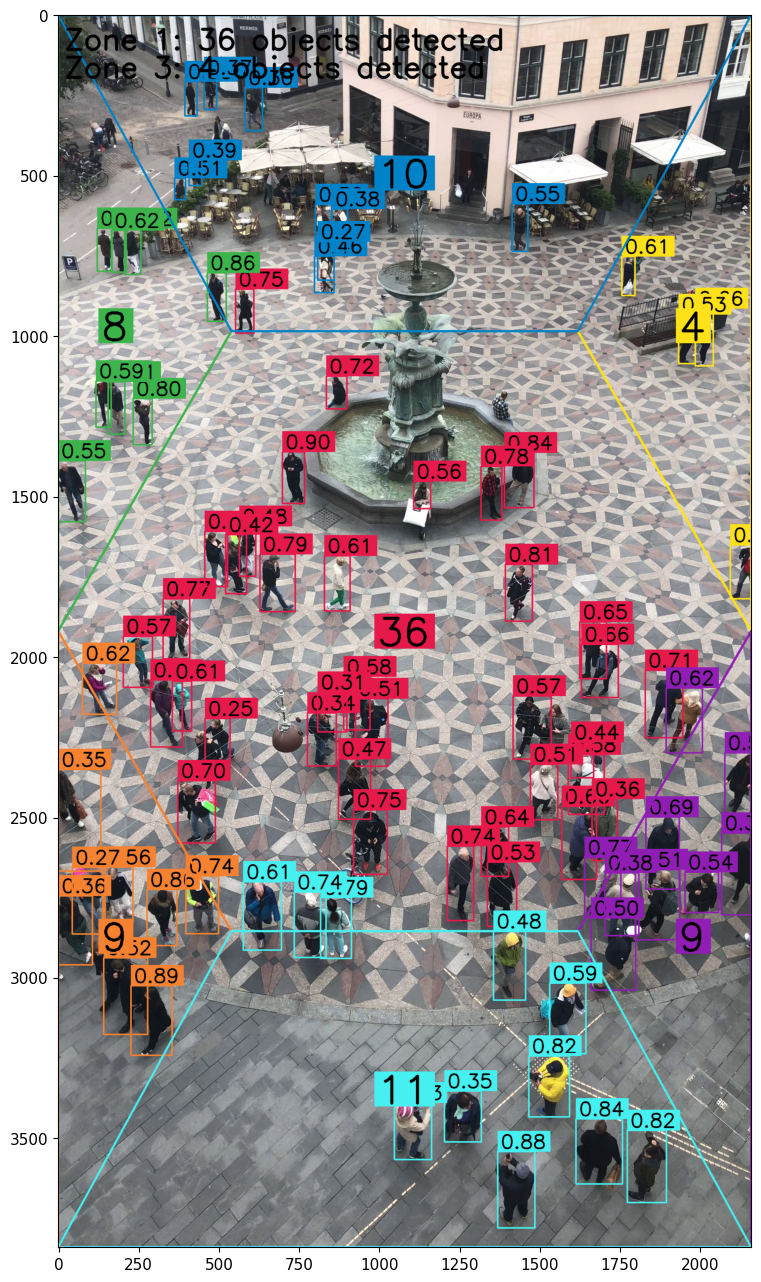

In [ ]:
colors = sv.ColorPalette.default()
polygons = [
    np.array([
        [540,  985 ],
        [1620, 985 ],
        [2160, 1920],
        [1620, 2855],
        [540,  2855],
        [0,    1920]
    ], np.int32),
    np.array([
        [0,    1920],
        [540,  985 ],
        [0,    0   ]
    ], np.int32),
    np.array([
        [1620, 985 ],
        [2160, 1920],
        [2160,    0]
    ], np.int32),
    np.array([
        [540,  985 ],
        [0,    0   ],
        [2160, 0   ],
        [1620, 985 ]
    ], np.int32),
    np.array([
        [0,    1920],
        [0,    3840],
        [540,  2855]
    ], np.int32),
    np.array([
        [2160, 1920],
        [1620, 2855],
        [2160, 3840]
    ], np.int32),
    np.array([
        [1620, 2855],
        [540,  2855],
        [0,    3840],
        [2160, 3840]
    ], np.int32)
]
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=6,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]

video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)

detections = sv.Detections(
    xyxy=detections.xyxy[detections.class_id == 0],
    confidence=detections.confidence[detections.class_id == 0],
    class_id=detections.class_id[detections.class_id == 0],
    tracker_id=None
)

zone_objects_count = {}

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    f_detections = [detection for i, detection in enumerate(detections) if mask[i]]
    frame = box_annotator.annotate(scene=frame, detections=f_detections)
    frame = zone_annotator.annotate(scene=frame)

    num_detections_in_zone = sum(mask)

    # Store zone number and the number of detections in the dictionary
    zone_objects_count[zone_annotators.index(zone_annotator) + 1] = num_detections_in_zone


max_zone = max(zone_objects_count, key=zone_objects_count.get)
min_zone = min(zone_objects_count, key=zone_objects_count.get)

# Calculate text size
font_scale = 3
text_thickness = 7
text_size_max = cv2.getTextSize(f"Zone {max_zone}: {zone_objects_count[max_zone]} objects detected", cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_thickness)[0]
text_size_min = cv2.getTextSize(f"Zone {min_zone}: {zone_objects_count[min_zone]} objects detected", cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_thickness)[0]

# Calculate text position for zone with highest number of objects detected
text_position_max = (20, 40 + text_size_max[1])

# Calculate text position for zone with lowest number of objects detected
text_position_min = (20, text_position_max[1] + 20 + text_size_min[1])

# Add text annotations for zone with highest number of objects detected
cv2.putText(frame, f"Zone {max_zone}: {zone_objects_count[max_zone]} objects detected", text_position_max, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), text_thickness, cv2.LINE_AA)

# Add text annotations for zone with lowest number of objects detected
cv2.putText(frame, f"Zone {min_zone}: {zone_objects_count[min_zone]} objects detected", text_position_min, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), text_thickness, cv2.LINE_AA)

output_image_path = "output_image.jpg"
cv2.imwrite(output_image_path, frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))
